Epoch: 001, Loss: 1.9554
Epoch: 002, Loss: 1.8619
Epoch: 003, Loss: 1.7662
Epoch: 004, Loss: 1.6488
Epoch: 005, Loss: 1.5146
Epoch: 006, Loss: 1.3803
Epoch: 007, Loss: 1.2630
Epoch: 008, Loss: 1.1256
Epoch: 009, Loss: 1.0111
Epoch: 010, Loss: 0.9141
Epoch: 011, Loss: 0.8171
Epoch: 012, Loss: 0.6771
Epoch: 013, Loss: 0.6491
Epoch: 014, Loss: 0.5578
Epoch: 015, Loss: 0.4854
Epoch: 016, Loss: 0.4470
Epoch: 017, Loss: 0.3752
Epoch: 018, Loss: 0.3723
Epoch: 019, Loss: 0.3181
Epoch: 020, Loss: 0.2982
Epoch: 021, Loss: 0.2438
Epoch: 022, Loss: 0.2470
Epoch: 023, Loss: 0.2045
Epoch: 024, Loss: 0.1884
Epoch: 025, Loss: 0.1320
Epoch: 026, Loss: 0.1784
Epoch: 027, Loss: 0.1303
Epoch: 028, Loss: 0.1247
Epoch: 029, Loss: 0.1185
Epoch: 030, Loss: 0.1160
Epoch: 031, Loss: 0.1158
Epoch: 032, Loss: 0.1169
Epoch: 033, Loss: 0.0870
Epoch: 034, Loss: 0.1127
Epoch: 035, Loss: 0.0906
Epoch: 036, Loss: 0.0784
Epoch: 037, Loss: 0.0673
Epoch: 038, Loss: 0.0609
Epoch: 039, Loss: 0.0701
Epoch: 040, Loss: 0.0642


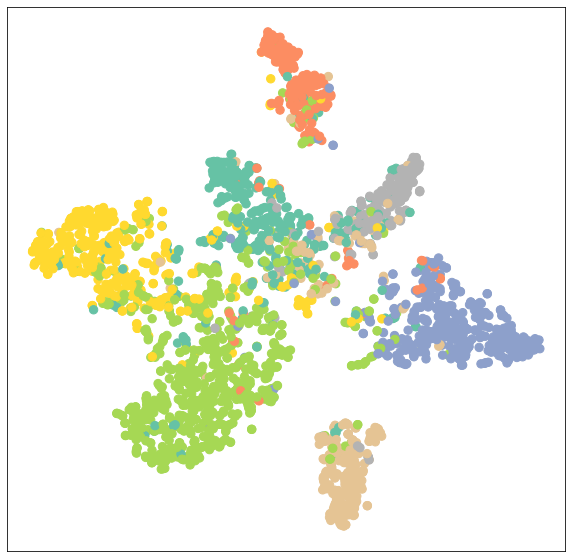

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid # 下载数据集使用
from torch_geometric.transforms import NormalizeFeatures
import requests
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#到国内gitee镜像下载
# base_url = "https://gitee.com/jiajiewu/planetoid/raw/master/data/ind.cora."
# names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
# for name in names:  
#     file_url = base_url+name
#     # print(file_url)
#     r = requests.get(file_url)
#     with open('/root/data/Planetoid/Cora/raw/ind.cora.'+name, 'wb') as f:
#         f.write(r.content)

dataset=Planetoid(root=r'/root/data/Planetoid',name="Cora")  #直接下载可能出现网络问题
data = dataset[0]
# 检查CUDA是否可用
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(data)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
#print(model)
# 将模型移动到GPU
model = model.to(DEVICE)  

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def lookmodel():
    model.eval()
    x = data.x.to(DEVICE)
    edge_index = data.edge_index.to(DEVICE)
    out = model(x, edge_index)
    visualize(out, color=data.y)  
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      x = data.x.to(DEVICE)
      edge_index = data.edge_index.to(DEVICE)
      out = model(x, edge_index)
      data_y_data_train_mask=data.y[data.train_mask].to(DEVICE)
      loss = criterion(out[data.train_mask], data_y_data_train_mask)
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      x = data.x.to(DEVICE)
      edge_index = data.edge_index.to(DEVICE)
      out = model(x, edge_index)
      pred = out.argmax(dim=1)
      data_test_mask = data.test_mask.to(DEVICE)
      data_y_data_test_mask = data.y[data_test_mask].to(DEVICE)
      test_correct = pred[data_test_mask] == data_y_data_test_mask
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

lookmodel()

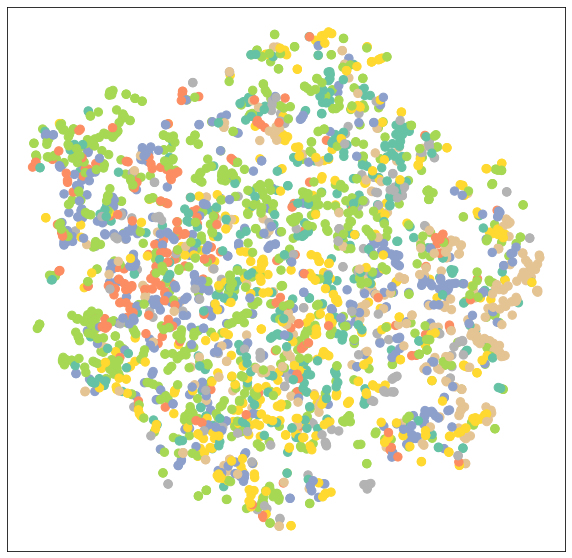

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid # 下载数据集使用
from torch_geometric.transforms import NormalizeFeatures
import requests
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#到国内gitee镜像下载
# base_url = "https://gitee.com/jiajiewu/planetoid/raw/master/data/ind.cora."
# names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
# for name in names:  
#     file_url = base_url+name
#     # print(file_url)
#     r = requests.get(file_url)
#     with open('/root/data/Planetoid/Cora/raw/ind.cora.'+name, 'wb') as f:
#         f.write(r.content)

dataset=Planetoid(root=r'/root/data/Planetoid',name="Cora")  #直接下载可能出现网络问题
data = dataset[0]
# print(data)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
#print(model)
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)